# Convolutional Autoencoder-Classifier

In [ ]:
# import the dependency libraries
import numpy as np

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU, Dense, Flatten, Conv1D, Conv1DTranspose, MaxPooling1D, Input, BatchNormalization, MaxPool1D 
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds # To load the datasets
import tensorflow_hub as hub       # Used for Transfer learning

import matplotlib.pyplot as plt

In [ ]:
# To know all available datasets in Tensorflow_hub are
#tfds.list_builders()

### Download IMBD dataset

In [ ]:
# Load the IMBD data set into (train(80%), Validation(20%)) of 25000 examples and Testdataset(100%) of 25000 examples.
train_data, validation_data, test_data = tfds.load(name="imdb_reviews", 
                                                  split=('train[:80%]', 'train[80%:]', 'test'), # split the dataset into Train, Validation, and Test dataset
                                                  as_supervised=True   # Returns tuple structure (input, label)
                                                  )

In [ ]:
#Unpack the train dataset
train_examples_batch, train_labels_batch = next(iter(train_data.batch(20000)))

#Unpack the validation dataset
val_examples_batch, val_labels_batch = next(iter(validation_data.batch(5000)))

#Unpack the validation dataset
X_test_examples, y_test_labels = next(iter(test_data.batch(25000)))

# view some samples of dataset
train_examples_batch[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [ ]:
next(iter(train_data.shuffle(5).batch(2)))

(<tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
        b'As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but when no "men" 

In [ ]:
# view some label dataset
train_labels_batch

<tf.Tensor: shape=(20000,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

### Word Embedding
One way to represent the text is to convert sentences into embeddings vectors. Use a pre-trained text embedding as the first layer, which will have three advantages:

* You don't have to worry about text preprocessing,
* Benefit from transfer learning,
* the embedding has a fixed size, so it's simpler to process.

Here we use **nnlm-en-dim50** pretrained module for token based text embedding which is trained on English Google News 7B corpus.

In [ ]:
# Load the pretrained module to encode the text dataset
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

# create Hub layer which converts text into embedding vector
hub_layer = hub.KerasLayer(embed, input_shape=[], # Expects a tensor of shape [batch_size] as input.
                           dtype=tf.string,       # Expects a tf.string input tensor.
                           trainable=False        # Make Embedding as trainable
                           )

In [ ]:
# embedding of train dataset
Xembd_layer = hub_layer(train_examples_batch)

# embedding of validation dataset
val_emb_dataset = hub_layer(val_examples_batch)

# embedding test dataset
test_emb_dataset = hub_layer(X_test_examples)

#shape of train dataset
print(Xembd_layer.shape)

#shape of validation dataset
print(val_emb_dataset.shape)

(20000, 50)
(5000, 50)


In [ ]:
# View some samples of Embedded training dataset
Xembd_layer[:2]

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

Here Each sentance is represented into 50 dimensional vectors.

### Reshape Train_Dataset
As you might remember, Conv1D layer expects input shape in 3D as

[batch_size, time_steps, input_dimension]

However, current data is in the shape of

[batch_size, features]

In [ ]:
SAMPLE_SIZE = Xembd_layer.shape[0] # number of samples in train set
TIMESTEPS  = Xembd_layer.shape[1] # number of features in train set
N_FEATURES = 1               # each feature is represented by 1 number

#Reshape the dataset
train_data_reshaped = tf.reshape(Xembd_layer, [SAMPLE_SIZE,TIMESTEPS,N_FEATURES])

print("After reshape train data set shape: ", train_data_reshaped.shape)
print("1 Sample shape: ",Xembd_layer[0].shape)
print("An example sample:\n", Xembd_layer[0])

After reshape train data set shape:  (20000, 50, 1)
1 Sample shape:  (50,)
An example sample:
 tf.Tensor(
[ 0.5423195  -0.0119017   0.06337538  0.06862972 -0.16776837 -0.10581174
  0.16865303 -0.04998824 -0.31148055  0.07910346  0.15442263  0.01488662
  0.03930153  0.19772711 -0.12215476 -0.04120981 -0.2704109  -0.21922152
  0.26517662 -0.80739075  0.25833532 -0.3100421   0.28683215  0.1943387
 -0.29036492  0.03862849 -0.7844411  -0.0479324   0.4110299  -0.36388892
 -0.58034706  0.30269456  0.3630897  -0.15227164 -0.44391504  0.19462997
  0.19528408  0.05666234  0.2890704  -0.28468323 -0.00531206  0.0571938
 -0.3201318  -0.04418665 -0.08550783 -0.55847436 -0.23336391 -0.20782952
 -0.03543064 -0.17533456], shape=(50,), dtype=float32)


### Reshape the validation dataset 

In [ ]:
# We need to reshape the validation dataset as well
val_SAMPLE_SIZE = val_emb_dataset.shape[0] # number of samples in train set
val_TIMESTEPS  = val_emb_dataset.shape[1]  # number of features in train set
val_N_FEATURES = 1                     # each feature is represented by 1 number

#Reshape the dataset
val_data_reshaped = tf.reshape(val_emb_dataset, [val_SAMPLE_SIZE, val_TIMESTEPS, val_N_FEATURES])

print("After reshape train data set shape: ", val_data_reshaped.shape)
print("1 Sample shape: ",val_emb_dataset[0].shape)
print("An example sample:\n", val_emb_dataset[0])

After reshape train data set shape:  (5000, 50, 1)
1 Sample shape:  (50,)
An example sample:
 tf.Tensor(
[ 9.7111344e-01  8.3876096e-02 -2.3345542e-01  4.0072110e-01
  5.3514248e-01 -3.3430302e-01  5.8403976e-02 -4.5053214e-02
 -2.8198385e-01  7.9080468e-01  1.9627273e-01  2.4578339e-01
  1.3954996e-05  2.4302465e-01 -4.9030185e-01 -1.0163963e-01
 -2.9281303e-01  1.9660410e-01 -5.2004270e-02 -8.1745976e-01
 -6.7622498e-02 -2.1134062e-01  4.1776115e-01 -1.1303243e-01
 -2.8801519e-01  3.5838264e-01 -1.2306654e+00  2.4650088e-01
  2.4441591e-01 -5.1148921e-01 -2.3490804e-01  3.8145795e-01
  5.3663242e-01 -4.3924636e-01 -3.4829819e-01  3.6493841e-01
 -1.6470081e-01 -2.0877215e-01  1.1981481e-01 -6.7716628e-01
  5.5227824e-03  3.5140291e-01 -4.3553081e-01  3.0726346e-01
 -2.0936011e-01  4.8649479e-02 -2.9413393e-01 -4.4267365e-01
  2.0608190e-02 -6.8088852e-02], shape=(50,), dtype=float32)


### Reshape test_Dataset

In [ ]:
SAMPLE_SIZE = test_emb_dataset.shape[0] # number of samples in train set
TIMESTEPS  = test_emb_dataset.shape[1] # number of features in train set
N_FEATURES = 1               # each feature is represented by 1 number

#Reshape the dataset
test_data_reshaped = tf.reshape(test_emb_dataset, [SAMPLE_SIZE,TIMESTEPS,N_FEATURES])

print("After reshape train data set shape: ", test_data_reshaped.shape)
print("1 Sample shape: ",test_emb_dataset[0].shape)
print("An example sample:\n", test_emb_dataset[0])

After reshape train data set shape:  (25000, 50, 1)
1 Sample shape:  (50,)
An example sample:
 tf.Tensor(
[ 0.6750989   0.20966221 -0.24682619  0.70157504  0.00509059 -0.04043961
 -0.13563964  0.15544751 -0.6535283   0.24198306 -0.14894551 -0.00701114
 -0.28954473  0.2347527  -0.07211338 -0.26374155 -0.2103376   0.19537686
  0.20801611 -0.53941184  0.09185641 -0.23350327  0.4647283   0.02278872
 -0.4248397  -0.3470194  -0.5100059  -0.0632058   0.11524688 -0.36703324
 -0.4015741   0.22107722  0.0946885  -0.21738936 -0.31970024  0.4252959
  0.44440353  0.04942252  0.23904411 -0.48945317 -0.06317567  0.07366529
 -0.2791622   0.02657618 -0.24505381 -0.11724484 -0.2243641  -0.04366887
  0.10280503  0.18705933], shape=(50,), dtype=float32)


## Model Building:
Model Building by using Convolutional Autoencoder-Classifier

* An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.
* There are mainly 3 ways to force the autoencoder to learn useful features:
  1. **keeping the code size small** : Keeping the code layer small forced our autoencoder to learn an intelligent representation of the data
  2. **Denoising Autoencoders**: Adding random noise to its inputs and making it recover the original noise-free data. This way the autoencoder can’t simply copy the input to its output because the input also contains random noise. We are asking it to subtract the noise and produce the underlying meaningful data.
  3. **Sparse Autoencoder**: A sparse autoencoder is simply an autoencoder whose training criterion involves a sparsity penalty. In most cases, we would construct our loss function by penalizing activations of hidden layers so that only a few nodes are encouraged to activate when a single sample is fed into the network

For this example we use Sparse Autoencoder method to build a model.


In [ ]:
# Sparse convolutional autoencoder

inputs = Input(shape=(TIMESTEPS, N_FEATURES), name ='encoder_input')

# Encoder Function 
def encoder ( inp ):

  #1st layer of encoder of Conv1D should have same units should have number of input dimension
  conv1 = Conv1D(filters = N_FEATURES, kernel_size =3, padding='same',activation='relu', name= 'encoder-conv1')(inp)
  
  #act = LeakyReLU(alpha=0.1)(conv1)
  #norm = BatchNormalization()(act)
  #conv2 = Conv1D(filters = N_FEATURES, kernel_size =3, padding='same', name= 'encoder-conv2')(norm)
  #act2 = LeakyReLU(alpha=0.1)(conv1)
  #norm = BatchNormalization()(act2)

  # Add pooling layer
  pool1 = MaxPool1D(pool_size=3, strides=1, padding='same', name='encoder-pool1')(conv1)

  # Encoding layer
  encoding = Dense(units=N_FEATURES, # Note: we can also change the nerons in this layer
                   activation='linear',
                   activity_regularizer = tf.keras.regularizers.L1( l1 = 0.01), # Add regulizer term to this layer to get sparsity 
                   name = 'encoder-dense')(pool1)
 

  # now return the encoding values
  return encoding


In [ ]:
encode = Model(inputs = inputs, outputs=encoder(inputs))
encode.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 50, 1)]           0         
_________________________________________________________________
encoder-conv1 (Conv1D)       (None, 50, 1)             4         
_________________________________________________________________
encoder-pool1 (MaxPooling1D) (None, 50, 1)             0         
_________________________________________________________________
encoder-dense (Dense)        (None, 50, 1)             2         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# lets see the outputs values of encoder model by taking 1 sample example
encode.predict(test_data_reshaped[0])

array([[[0.        ]],

       [[0.        ]],

       [[0.12213753]],

       [[0.        ]],

       [[0.        ]],

       [[0.02001082]],

       [[0.06711885]],

       [[0.        ]],

       [[0.32338682]],

       [[0.        ]],

       [[0.07370303]],

       [[0.00346934]],

       [[0.14327604]],

       [[0.        ]],

       [[0.03568402]],

       [[0.1305078 ]],

       [[0.10408179]],

       [[0.        ]],

       [[0.        ]],

       [[0.26691833]],

       [[0.        ]],

       [[0.11554492]],

       [[0.        ]],

       [[0.        ]],

       [[0.21022435]],

       [[0.17171636]],

       [[0.2523673 ]],

       [[0.03127626]],

       [[0.        ]],

       [[0.18161985]],

       [[0.19871178]],

       [[0.        ]],

       [[0.        ]],

       [[0.10757124]],

       [[0.15819795]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.24219716]],

       [[0.03126135]],

       [[0.     

Inference : We can see that, The prediction of encoder is Sparse matric. This is caused due to adding regularization method in last layer of encoder where it penalize the less important values for prdiction to zeros.

In [ ]:
# Decoder Function
def decoder(encoding):
  # add Transpose Convolution layer to convolve and upsample the Encoder output to reconstruct back the original inputs back.
  convT1 = Conv1DTranspose(filters=N_FEATURES, kernel_size=3, activation='linear', padding='same')(encoding)

  #applying BatchNormalization to prevent from exploding gradients                 
  #decoding = BatchNormalization()(convT1)

  #conv11 = Conv1D(filters = 2, kernel_size =3, padding='same',activation='relu', name= 'encoder-conv11')(decoding)

  #pool11 = MaxPool1D(pool_size=2, strides=1, padding='same', name='encoder-pool11')(convT1)

  decoding = BatchNormalization()(convT1)

  # final layer of decoder
  decoding = Dense(units=N_FEATURES, 
                   activation ='linear')(decoding)

  return decoding

In [ ]:
# Group layers of encoder and decoder into an object with training and inference features.
autoencoder = Model(inputs=inputs, outputs = decoder(encoder(inputs)))

#Get the summary of Autoencoder
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 50, 1)]           0         
_________________________________________________________________
encoder-conv1 (Conv1D)       (None, 50, 1)             4         
_________________________________________________________________
encoder-pool1 (MaxPooling1D) (None, 50, 1)             0         
_________________________________________________________________
encoder-dense (Dense)        (None, 50, 1)             2         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 50, 1)             4         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 1)             4         
_________________________________________________________________
dense (Dense)                (None, 50, 1)             2   

In [ ]:
# autoencoder model compilation 
autoencoder.compile(loss = 'mean_squared_error',  optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
history = autoencoder.fit(x =train_data_reshaped, y=train_data_reshaped, epochs=50, batch_size=150, 
                          validation_data=(val_data_reshaped, val_data_reshaped), 
                          verbose=1).history

Epoch 1/50
134/134 [==============================] - 2s 11ms/step - loss: 2.2358 - mean_absolute_error: 1.0836 - val_loss: 0.5262 - val_mean_absolute_error: 0.4441
Epoch 2/50
134/134 [==============================] - 1s 9ms/step - loss: 1.3175 - mean_absolute_error: 0.8222 - val_loss: 0.3999 - val_mean_absolute_error: 0.4444
Epoch 3/50
134/134 [==============================] - 1s 9ms/step - loss: 0.7578 - mean_absolute_error: 0.5936 - val_loss: 0.2507 - val_mean_absolute_error: 0.3291
Epoch 4/50
134/134 [==============================] - 1s 9ms/step - loss: 0.2681 - mean_absolute_error: 0.3461 - val_loss: 0.1861 - val_mean_absolute_error: 0.3188
Epoch 5/50
134/134 [==============================] - 1s 9ms/step - loss: 0.1803 - mean_absolute_error: 0.3181 - val_loss: 0.1790 - val_mean_absolute_error: 0.3170
Epoch 6/50
134/134 [==============================] - 1s 9ms/step - loss: 0.1761 - mean_absolute_error: 0.3152 - val_loss: 0.1738 - val_mean_absolute_error: 0.3122
Epoch 7/50
134/

### Convolutional Classifier Initialized with Encoder
A classifier can be (potentially) enhanced with an autoencoder. Listing constructs a feed-forward convolutional classifier with an encoder
attached to it.

In [ ]:
#  CNN Classifier initialized with Encoder
def fully_connected ( encoding ):
  # convolution 1d layer
  conv1 = Conv1D(filters =20, kernel_size=3, activation='relu' ,padding='valid', name = 'fc-con1')(encoding)

  #conv2 = Conv1D(filters =20, kernel_size=3, padding='valid', activation='relu', name = 'fc-con2')(conv1)

  # Pooling layer
  pool1 = MaxPool1D(pool_size=2, padding='valid', name ='fc-pool1')(conv1)
  
  #flatten the output of pooling layer
  flat1 = Flatten()(pool1)
   
  #Dense layer
  den = Dense(units=20, activation='relu')(flat1)
   
  # output layer
  output = Dense ( units =1, activation='sigmoid', name = 'output')(den)

  return(output)

encoding = encoder(inputs)

# Combine encoder(trained encoder) and fullyconnected models to get final output
Classifier = Model(inputs = inputs, outputs= fully_connected(encoding=encoder(inputs)))

The encoder can be used to have either a,
  * Pre-trained classifier. A trained encoder can be used as a part
of a feed-forward classifier network. Or,
  * Encoded features as input. The features produced by an encoder used as     input to a classifier.

Corresponding to the two approaches, an argument retrain_encoding
is defined in Listing.
The argument when set to False results in the classifier using the
encoded features as input. This is achieved by making the layers in the encoder section of the model as non-trainable in line 13 in the listing.
The argument, retrain_encoding, when set to True uses the encoding weights to initialize the model and retrain them while learning
the classifier.

In [ ]:
# layers in Classifer model
Classifier.layers

In [ ]:
# layers in Autoencoders
autoencoder.layers

In [ ]:
# Classifier layer initialized with encoder
retrain_encoding = False

# loop through every layers in classifier model
for classifier_layer in Classifier.layers : 

  # loop through every layers in autoencoder model
  for autoencoder_layer in autoencoder.layers:

    # Get the name of common layers(i.e, Encoder layers) 
    if classifier_layer.name == autoencoder_layer.name:

      # Set the weights of classifier same as the corresponding autoencoder(encoder) layer
      classifier_layer.set_weights(autoencoder_layer.get_weights())

      # Only train encoder model if user wants to train the encoder model
      if retrain_encoding == False: 
        # don't train the encoder model layers
        classifier_layer.trainable = False

        print(classifier_layer.name + 'in classifier set to ' + autoencoder_layer.name + 'in the encoder is trainable:' + 
              str(classifier_layer.trainable))
        
Classifier.summary()

encoder_inputin classifier set to encoder_inputin the encoder is trainable:False
encoder-conv1in classifier set to encoder-conv1in the encoder is trainable:False
encoder-pool1in classifier set to encoder-pool1in the encoder is trainable:False
encoder-densein classifier set to encoder-densein the encoder is trainable:False
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 50, 1)]           0         
_________________________________________________________________
encoder-conv1 (Conv1D)       (None, 50, 1)             4         
_________________________________________________________________
encoder-pool1 (MaxPooling1D) (None, 50, 1)             0         
_________________________________________________________________
encoder-dense (Dense)        (None, 50, 1)             2         
_________________________________________________________________

In [ ]:
# compile the Classifier model
Classifier.compile (optimizer= 'adam', loss= 'binary_crossentropy' , metrics =['accuracy', tf.keras.metrics.Recall()])

In [ ]:
#Train the model
history = Classifier.fit(x =train_data_reshaped, y=train_labels_batch.numpy(), epochs=100, 
                         validation_data=(val_data_reshaped, val_labels_batch.numpy()), verbose=1).history

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 0.6673 - accuracy: 0.6132 - recall: 0.6516 - val_loss: 0.6194 - val_accuracy: 0.6750 - val_recall: 0.6713
Epoch 2/100
625/625 [==============================] - 3s 5ms/step - loss: 0.6137 - accuracy: 0.6682 - recall: 0.6499 - val_loss: 0.6011 - val_accuracy: 0.6842 - val_recall: 0.7096
Epoch 3/100
625/625 [==============================] - 3s 5ms/step - loss: 0.6044 - accuracy: 0.6772 - recall: 0.6614 - val_loss: 0.6070 - val_accuracy: 0.6632 - val_recall: 0.8139
Epoch 4/100
625/625 [==============================] - 3s 4ms/step - loss: 0.5970 - accuracy: 0.6857 - recall: 0.6731 - val_loss: 0.5979 - val_accuracy: 0.6890 - val_recall: 0.5579
Epoch 5/100
625/625 [==============================] - 3s 4ms/step - loss: 0.5927 - accuracy: 0.6887 - recall: 0.6721 - val_loss: 0.5810 - val_accuracy: 0.6960 - val_recall: 0.7183
Epoch 6/100
625/625 [==============================] - 3s 4ms/step - loss: 0.5868 - accuracy: 0

In [ ]:
history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])

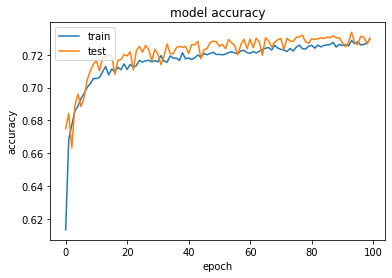

In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

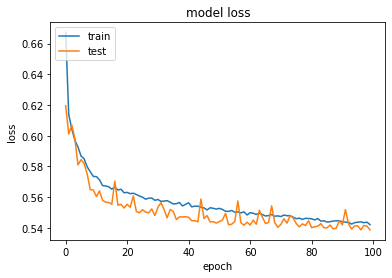

In [ ]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# prediction for unseen data
pred_Y = Classifier.predict(test_data_reshaped, verbose = True)
pred_Y = np.round(pred_Y)

782/782 [==============================] - 1s 1ms/step


In [ ]:
#get the accuracy_score for prediction # classifer
print('Accuracy for test dataset:',accuracy_score(y_test_labels.numpy(), pred_Y))

Accuracy for test dataset: 0.71968


In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_test_labels.numpy(), pred_Y)
print(conf_matrix)

[[9043 3457]
 [3551 8949]]


In [ ]:
# classification report
print(classification_report(y_test_labels.numpy(), pred_Y))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72     12500
           1       0.72      0.72      0.72     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000



### Logistic Regression
Now lets try with simple logistic regression. 

In [ ]:
# Instantiate the logistic regression
logreg = LogisticRegression()

In [ ]:
# Train the logistic model by fitting the train data
logreg = logreg.fit(Xembd_layer, train_labels_batch.numpy())

In [ ]:
# Now lets predict the validation dataset with trainded logistic model
prd = logreg.predict(test_emb_dataset)

In [ ]:
# Check for the accuracy score for model prediction
print('Accuracy for test dataset:',accuracy_score(y_test_labels.numpy(), prd))

Accuracy for test dataset: 0.7406


In [ ]:
# confusion matrix
confusion = confusion_matrix(y_test_labels.numpy(), prd)
print(confusion)

[[9476 3024]
 [3461 9039]]


In [ ]:
# classification
print(classification_report(y_test_labels.numpy(), prd))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75     12500
           1       0.75      0.72      0.74     12500

    accuracy                           0.74     25000
   macro avg       0.74      0.74      0.74     25000
weighted avg       0.74      0.74      0.74     25000



## Conclusion
* Here we created **Sentiment Analysis** models(Sparse_CNN_Autoencoder and Logistic_regression) by training it with IMBD dataset. Where a trained model can predict 1(Positive) or 0(Negative) for given user review.

* By comparing the results of Sparse Autoencoder of CNN model and Logistic regression models, Logistic regression performed well but it doesn't mean best model because CNN(Sparse Autoencoder) model only extracting important by learning redundant features in the dataset by preventing model overfitting.

* We can improve CNN model by modifying the CNN architecture, where it can learn latent features which are more affected the target variable.

